# 24-step horizon Traffic dataset with modified attention modules for Decoder-only transformer

In this notebook, we experiment on the [Traffic dataset](https://archive.ics.uci.edu/dataset/204/pems+sf) which contains occupancy rates of 963 traffic lanes. The preprocessed traffic dataset is used in which occupancy rates are measured every hour. Furthermore, we experiment on all attention modules in the non-overlapping setting.

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["pdf.use14corefonts"] = True

from src.Datasets.BaseDataset import BaseTimeSeriesDataset
from src.Transformer.DecoderOnly import PointDecoderOnlyTransformer
from src.train import train_step_dec_only, val_step_dec_only
from src.utils import collate_fn, EarlyStopping

# attention imports
from src.Transformer.TransformerModules import DotProductAttention
from src.Transformer.KernelAttention import LinearKernelAttention
from src.Transformer.KernelAttention import SEKernelAttention
from src.Transformer.KernelAttention import PeriodicKernelAttention
from src.Transformer.KernelAttention import LocallyPeriodicKernelAttention
from src.Transformer.KernelAttention import RationalQuadraticKernelAttention
from src.Transformer.KernelAttention import ImplicitKernelAttention
from src.Transformer.KernelAttention import ChangePointKernelAttention
from src.Transformer.ConvAttention import MultiFilterConvDotProductAttention

## Configuration

In [2]:
# configs
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# attention module
_attentions = {
    "scaled_dot_product": DotProductAttention(),
    "linear_kernel": LinearKernelAttention(),
    "SE_kernel": SEKernelAttention(p_norm=2),
    "periodic_kernel": PeriodicKernelAttention(p_norm=2, period=20),
    "LP_kernel": LocallyPeriodicKernelAttention(p_norm=2, period=20),
    "RQ_kernel": RationalQuadraticKernelAttention(p_norm=2, alpha=1),
    "IK_kernel": ImplicitKernelAttention(p_norm=2, R_features=64),
    "CP_kernel": ChangePointKernelAttention(p_norm=2, period=20),
    "conv_attention": MultiFilterConvDotProductAttention(kernel_size=3, num_filters=4),
}

# transformer configs
n_heads = 8                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
emb_size = 20                           # size of transformer block embedding (d_model)
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 2048                     # point-wise feed forward net hidden dimensions

# train configs
ps = [0.5, 0.9]                         # rho_quantile loss probs
lr = 0.0005                             # initial learning rate
lr_step_size = 10                       # every n steps decrease learning rate by gamma
lr_gamma = 0.95                         # learning rate decrease rate
EPOCHS = 300                            # training epochs
patience = 30                           # stop training after number of epochs without val loss improvement 

df = pd.read_csv("../../data/processed/traffic_1h.csv")
n_timeseries = df.shape[1]-2
covariate_dim = 2

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
X = torch.tensor(df.iloc[:, :covariate_dim].values, dtype=torch.float32)
fX = torch.tensor(df.iloc[:, 2:n_timeseries+2].values, dtype=torch.float32)

# Xrange = torch.arange(0, fX.shape[0]).unsqueeze(1)
norm_fX = (fX - fX.mean(dim=0, keepdim=True)) / fX.std(dim=0, keepdim=True)

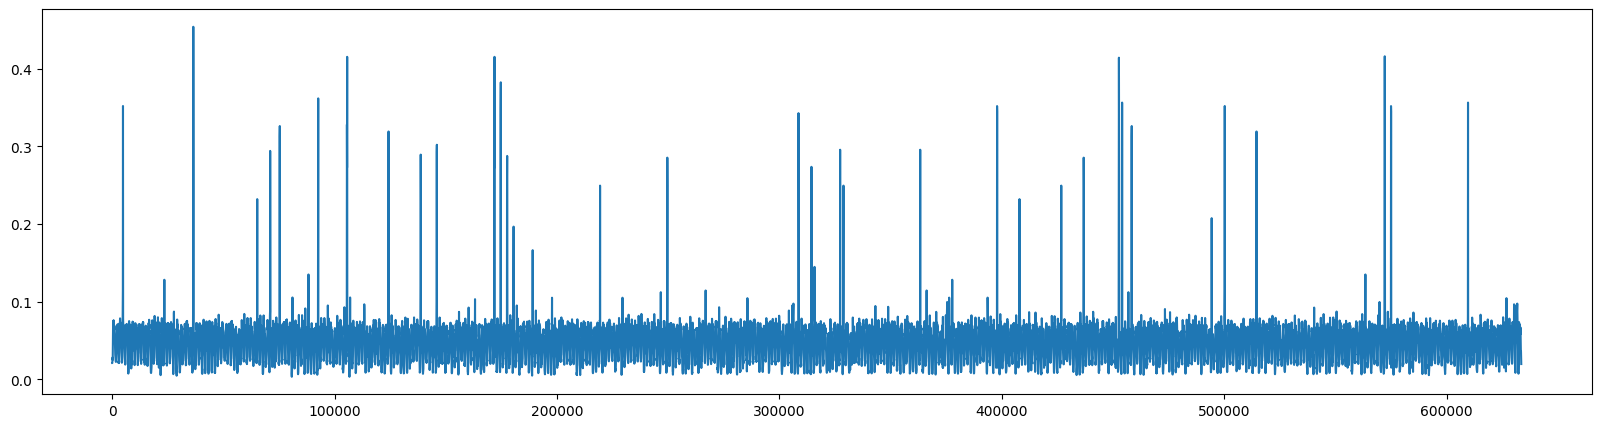

In [5]:
plt.figure(figsize=(20, 5))
plt.plot(df['minutes'], df['2'])

In [6]:
def create_models(attns):
    return {
        name: PointDecoderOnlyTransformer(
            d_in=n_timeseries+covariate_dim, 
            d_out=n_timeseries,
            emb_size=emb_size,
            n_heads=n_heads,
            n_hidden=n_hidden,
            ffn_n_hidden=ffn_n_hidden,
            _attention=attn,
            num_layers=n_layers,
            norm_first=True
        ).to(device) for name, attn in attns.items()
    }

## Dataset preparation

In [7]:
seq_len = 7*24   # sequence length of each sample
shift = 24       # number of steps to predict at once

dataset = BaseTimeSeriesDataset(X, norm_fX, seq_len=seq_len, shift=shift, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (0.8, 0.1, 0.1))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn, drop_last=True)
test_dl = DataLoader(test_set, batch_size=64, shuffle=True, collate_fn=collate_fn, drop_last=True)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn, drop_last=True)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(8295, 1036, 1037, 259, 16, 16)

(torch.Size([168, 2]),
 torch.Size([168, 963]),
 torch.Size([24, 2]),
 torch.Size([24, 963]))

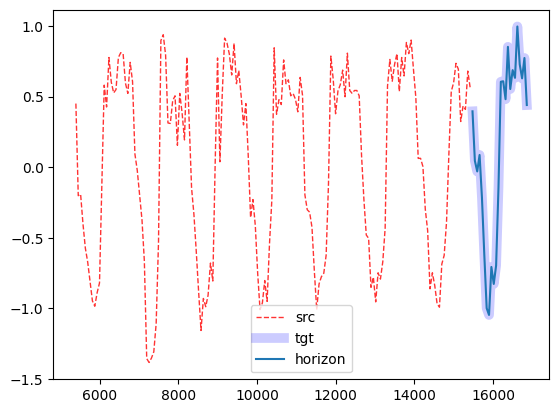

In [8]:
src_X, src_fX, tgt_X, tgt_fX = dataset[90]

plt.plot(src_X[:, 0], src_fX[:, 0], '--r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X[:, 0], tgt_fX[:, 0], '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:, 0], tgt_fX[-shift-1:, 0], label='horizon')
plt.legend()
src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

## Training setup

In [8]:
models = create_models(_attentions)

history = {}

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Training

In [9]:
for name, model in models.items():
    train_history = []
    val_history = []
    
    ES = EarlyStopping(patience=patience, delta=0)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)
    
    print(f"Start training {name}")
    for epoch in range(EPOCHS):
    
        train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
        train_history.append([train_loss, train_mape_loss])
    
        val_loss, val_mape_loss, _ = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
        val_history.append([val_loss, val_mape_loss])
        
        scheduler.step()
        
        if epoch % 10 == 0:
            print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}")
            if ES.best_model:
                path = f"../../models/{name}/traffic_{name}_{shift}preds.pth"
                torch.save(ES.best_model.state_dict(), path)
        
        ES(val_loss, model)
        # if ES.early_stop: break
    
    history[name] = (train_history, val_history)
    
    best_model = ES.best_model
    best_test_loss, best_test_mape_loss, _ = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)
    print(f"Test losses: {best_test_loss=:.4f}\t{best_test_mape_loss=:.4f}")
    
    path = f"../../models/{name}/traffic_{name}_{shift}preds.pth"
    torch.save(best_model.state_dict(), path)
    

Start training scaled_dot_product
epoch=0	train_loss=1.0131	val_loss=1.0026	train_mape_loss=2.1013	val_mape_loss=1.3168
epoch=10	train_loss=0.6074	val_loss=0.5989	train_mape_loss=6.0480	val_mape_loss=6.0853
epoch=20	train_loss=0.5845	val_loss=0.5801	train_mape_loss=5.9180	val_mape_loss=5.1183
epoch=30	train_loss=0.5745	val_loss=0.5675	train_mape_loss=5.9494	val_mape_loss=6.1023
epoch=40	train_loss=0.5681	val_loss=0.5636	train_mape_loss=5.8825	val_mape_loss=5.8360
epoch=50	train_loss=0.5621	val_loss=0.5550	train_mape_loss=5.8539	val_mape_loss=5.9484
epoch=60	train_loss=0.5562	val_loss=0.5497	train_mape_loss=5.8561	val_mape_loss=5.9236
epoch=70	train_loss=0.5505	val_loss=0.5419	train_mape_loss=5.8597	val_mape_loss=5.5080
epoch=80	train_loss=0.5456	val_loss=0.5369	train_mape_loss=5.8286	val_mape_loss=5.5322
epoch=90	train_loss=0.5394	val_loss=0.5304	train_mape_loss=5.7526	val_mape_loss=5.8492
epoch=100	train_loss=0.5318	val_loss=0.5230	train_mape_loss=5.6483	val_mape_loss=5.5012
epoch=110

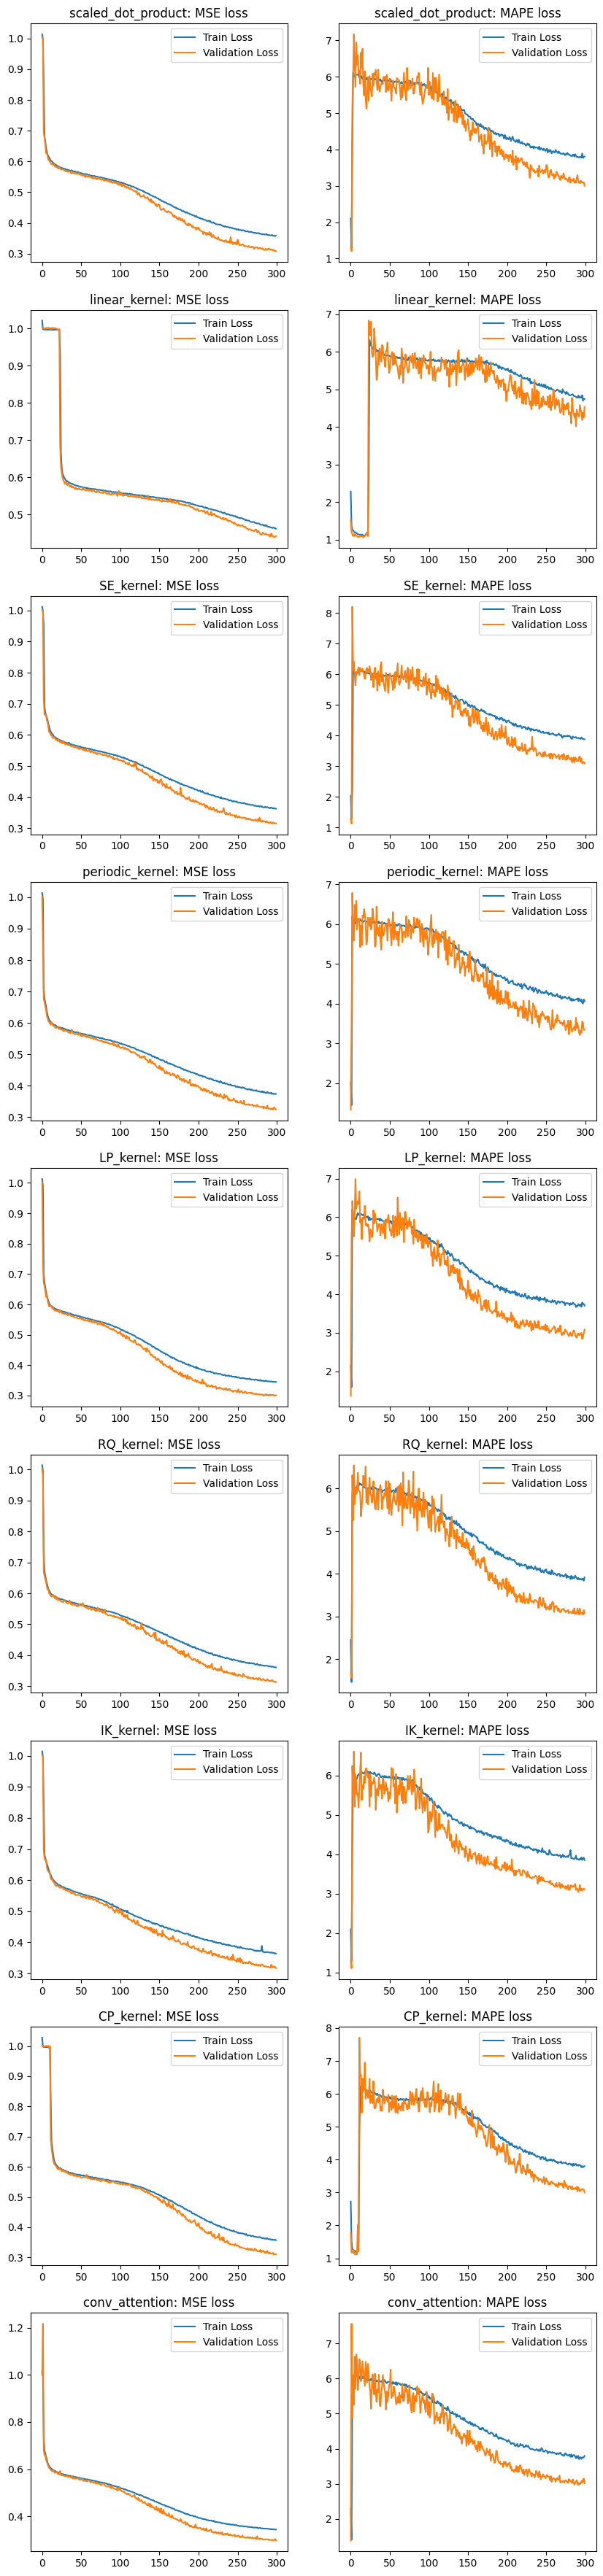

In [10]:
fig, axes = plt.subplots(len(models), 2, figsize=(10, 5*len(models)))

for ax, (name, (train_history, val_history)) in zip(axes, history.items()):
    tensor_train_history = torch.tensor(train_history)
    tensor_val_history = torch.tensor(val_history)
    
    ax[0].plot(tensor_train_history[:, 0], label="Train Loss")
    ax[0].plot(tensor_val_history[:, 0], label="Validation Loss")
    ax[0].set_title(f"{name}: MSE loss")
    ax[0].legend()
    
    ax[1].plot(tensor_train_history[:, 1], label="Train Loss")
    ax[1].plot(tensor_val_history[:, 1], label="Validation Loss")
    ax[1].set_title(f"{name}: MAPE loss")
    ax[1].legend()

## Predict

In [120]:
inspect_step = 0
ith = 29
idx = 24*(29)

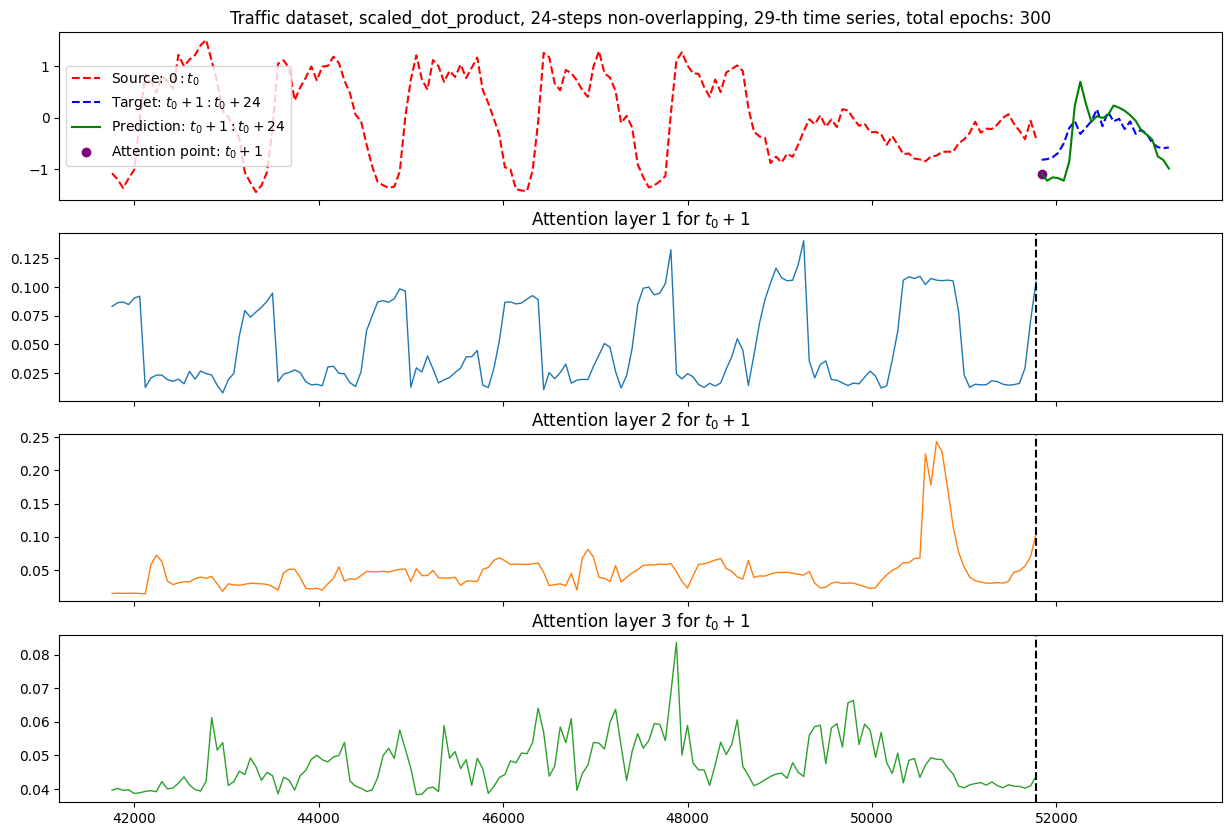

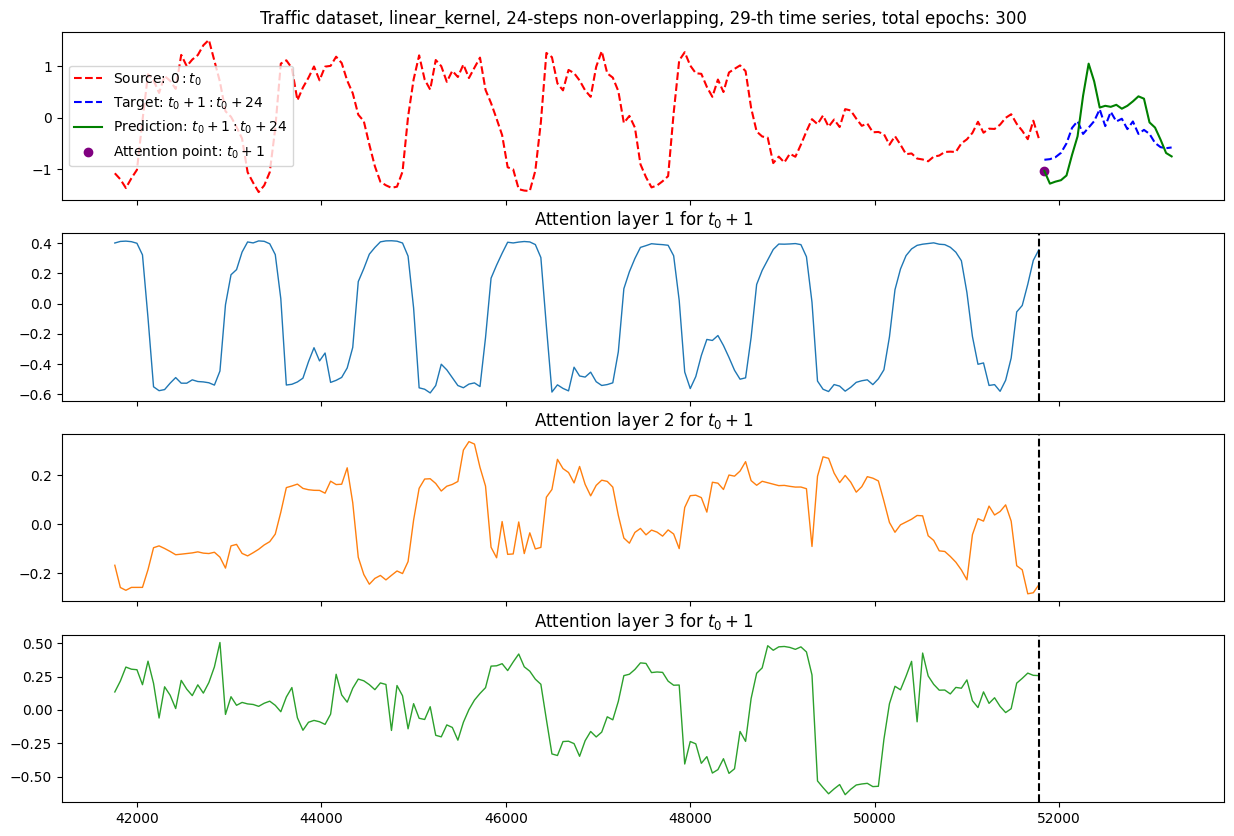

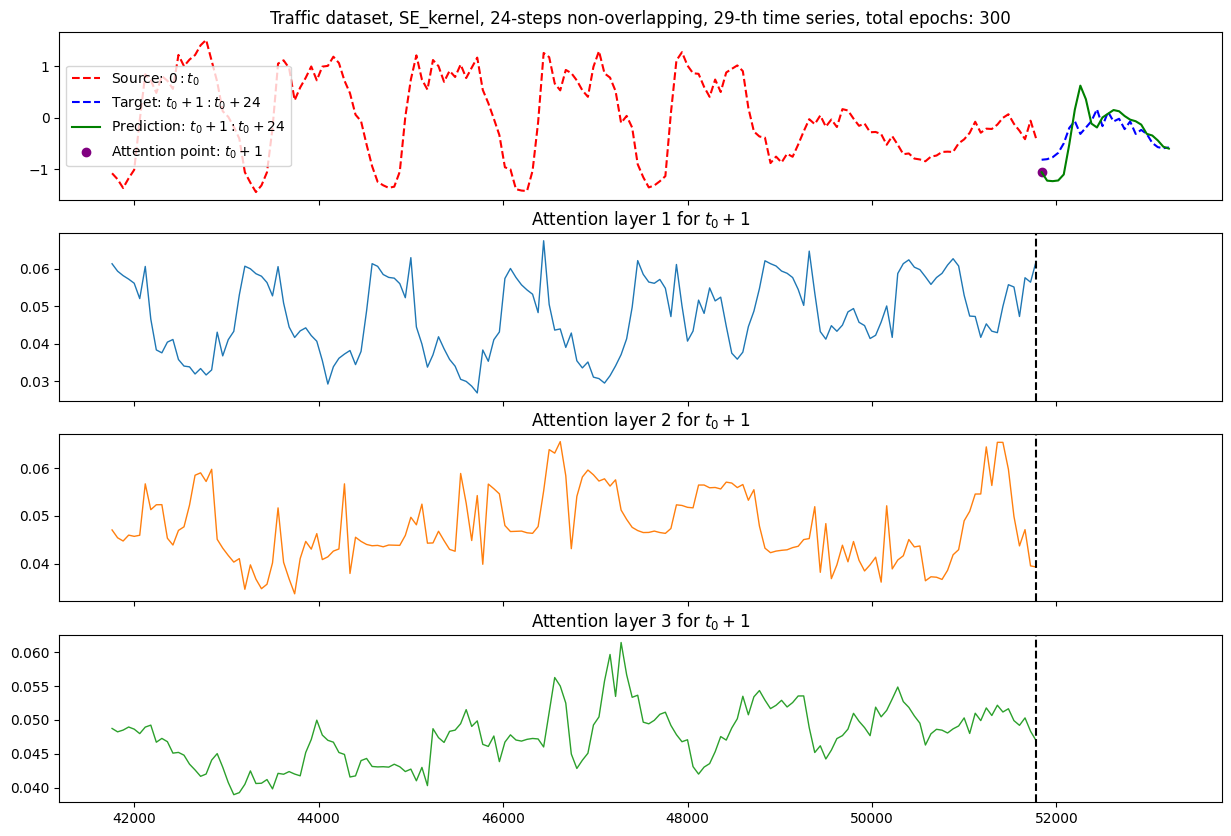

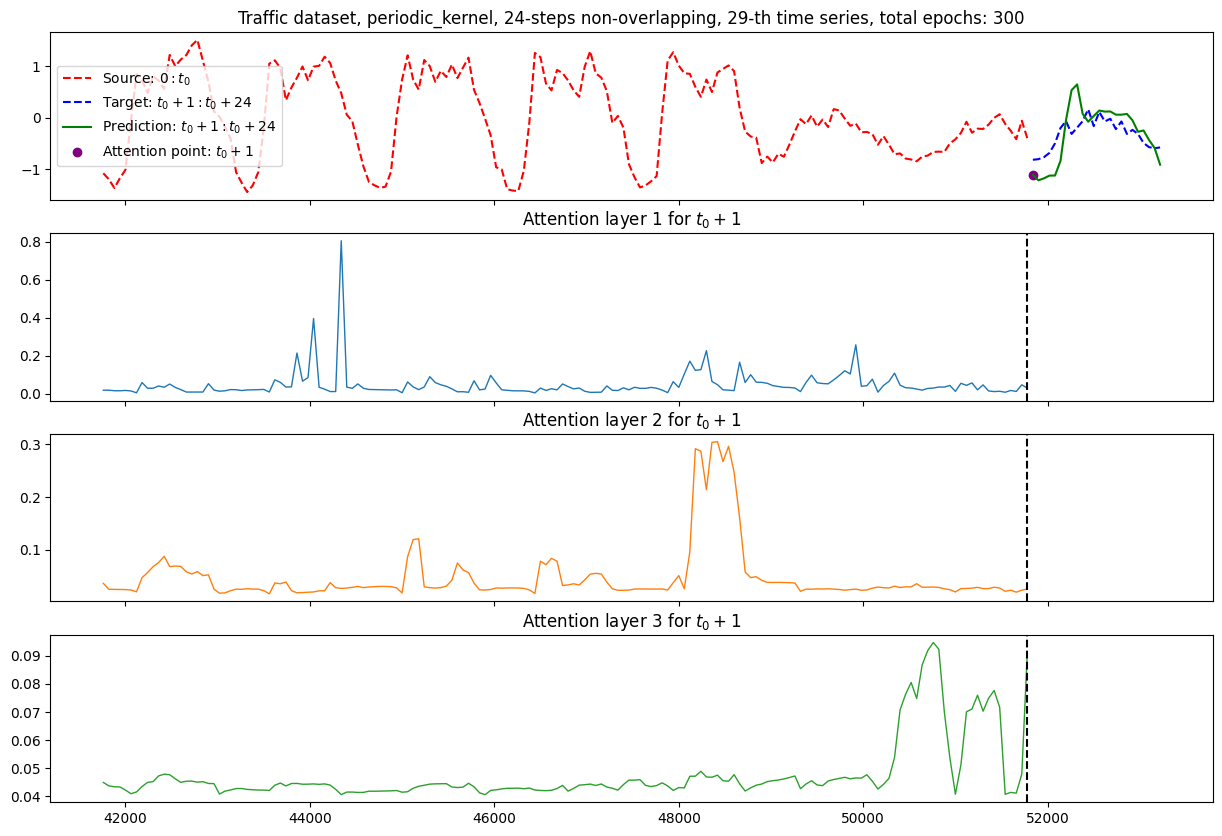

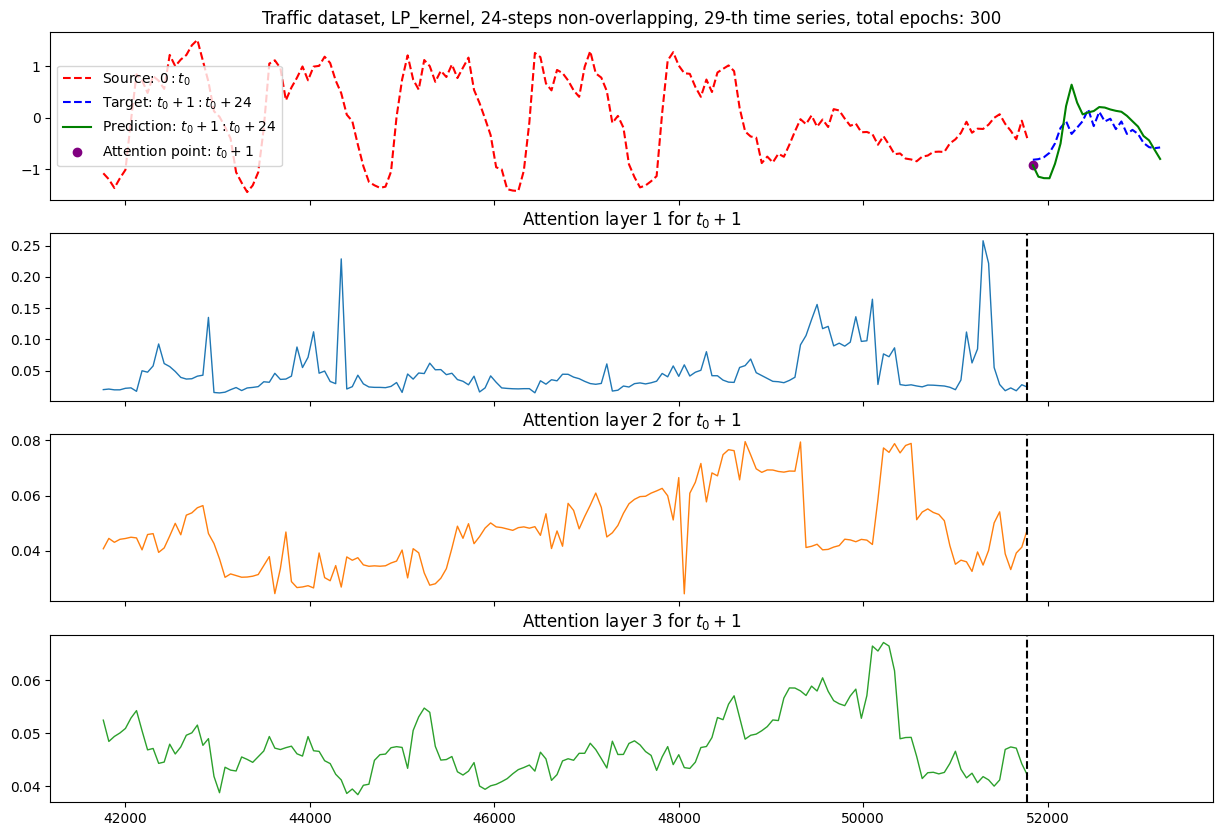

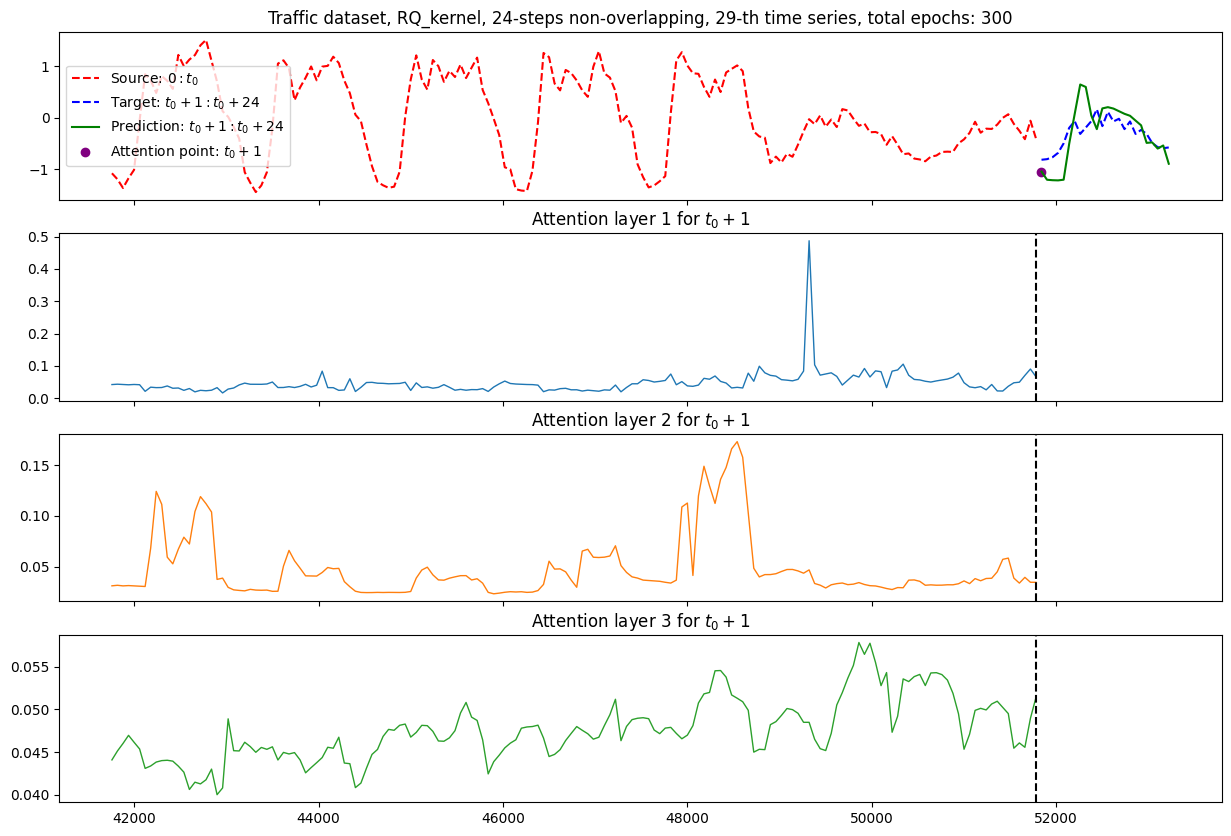

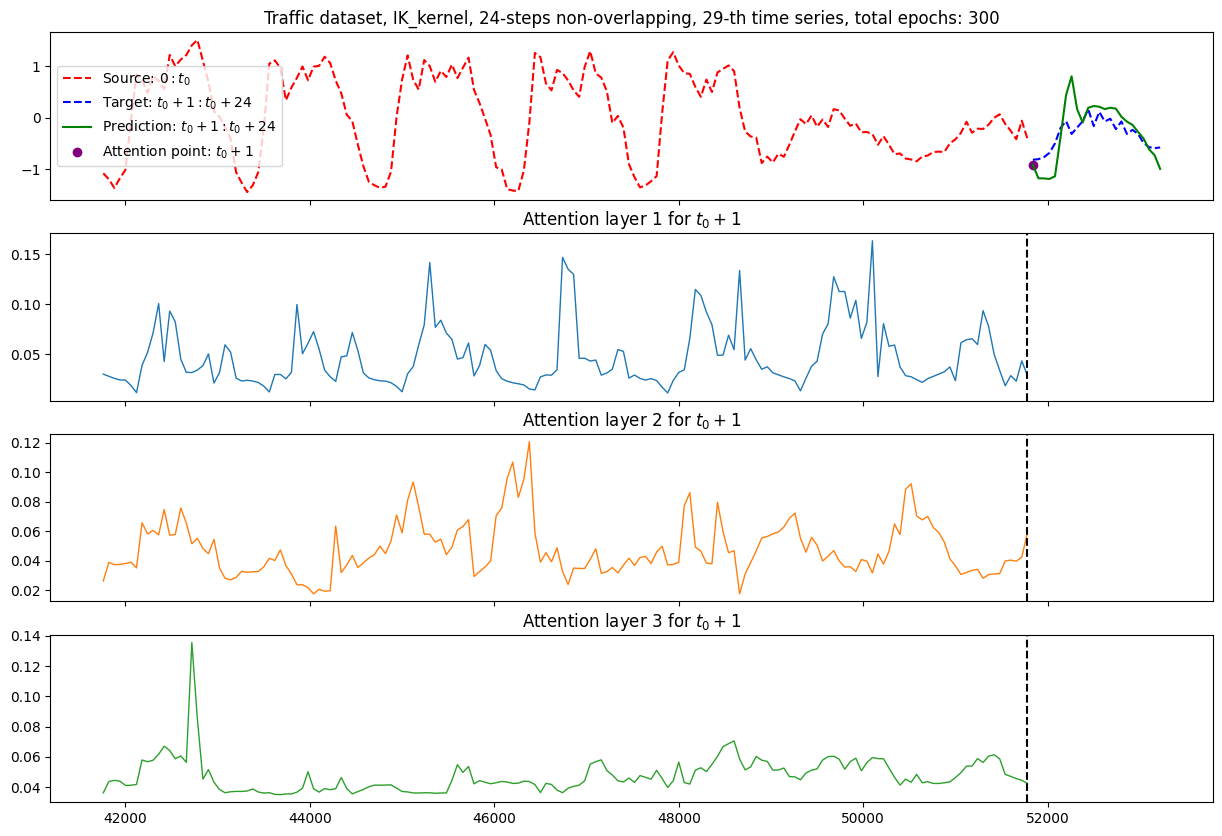

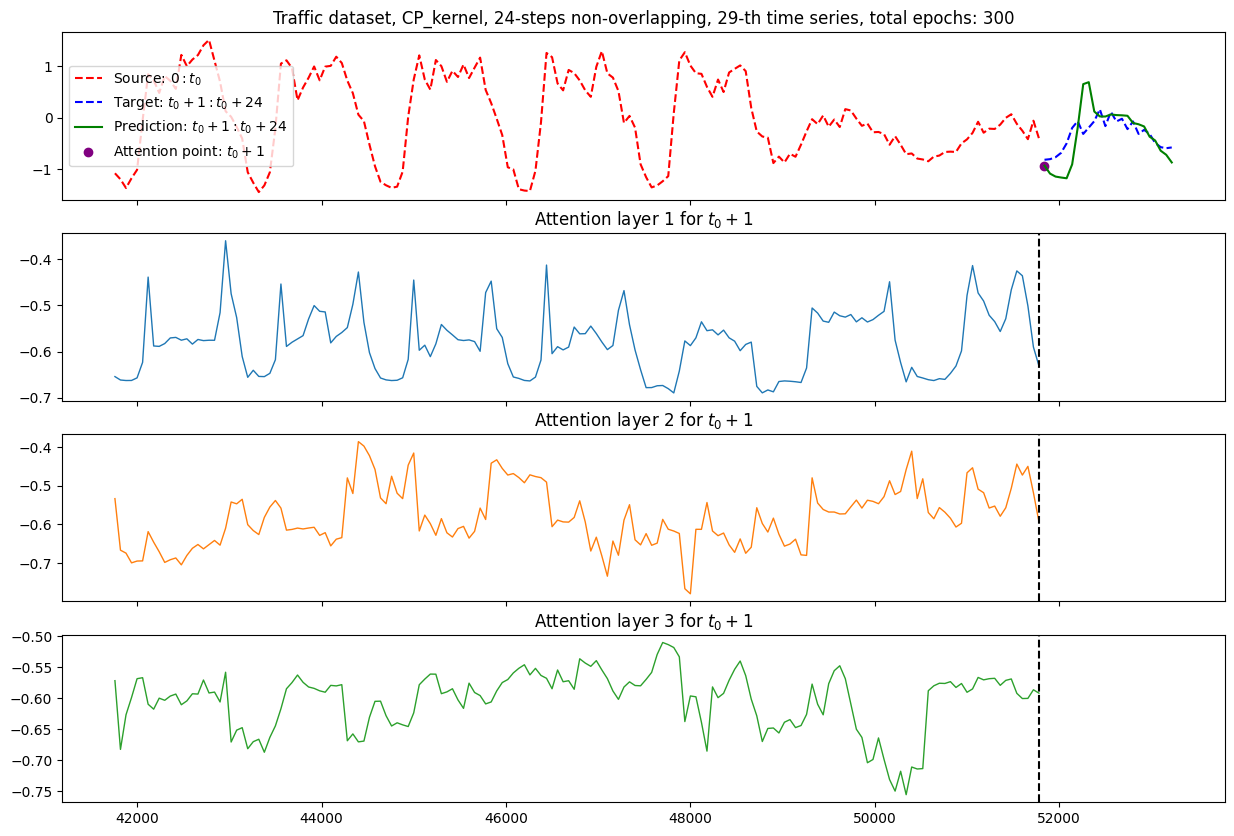

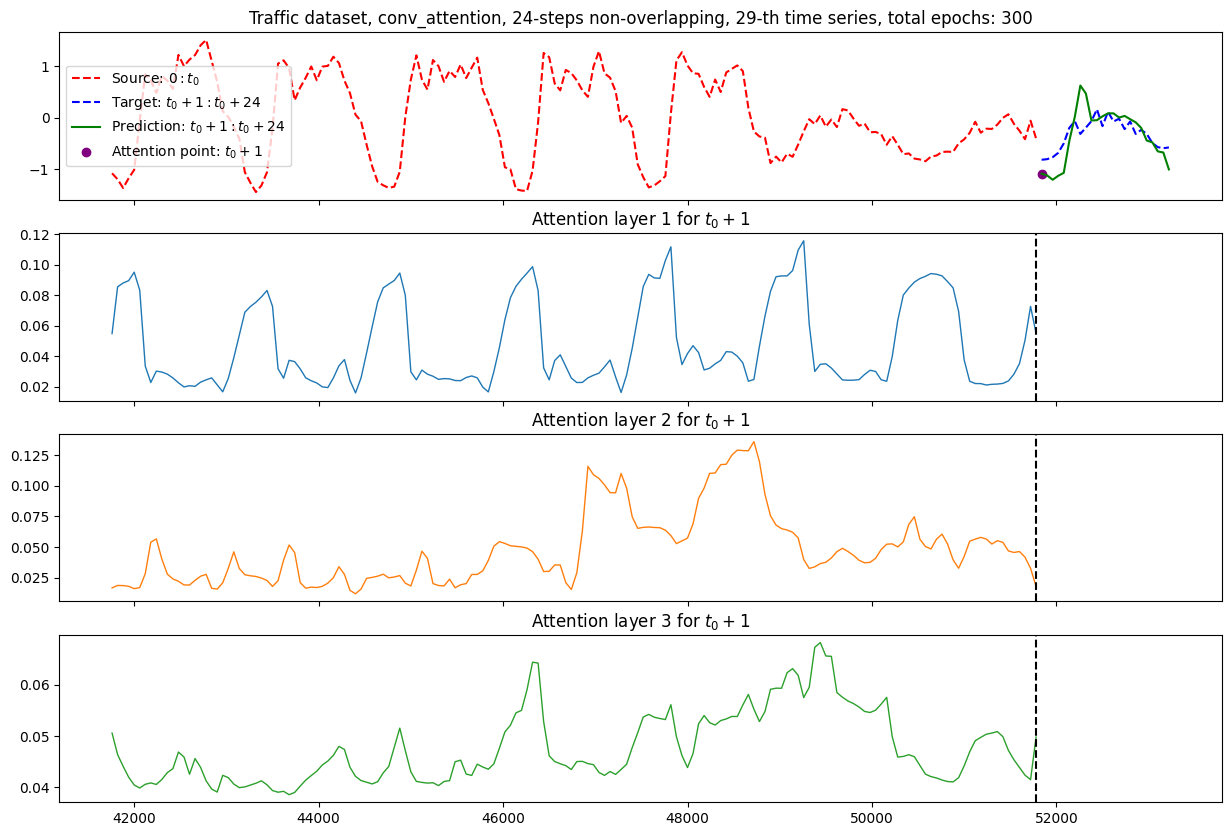

In [122]:
colors = ['C0', 'C1', 'C2'] 

for name, model in models.items():
    attention_weights = []

    with torch.no_grad():
        model.eval()
        sample = dataset[idx]
        src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
        mask = dataset.mask.to(device)
        
        out = model(src_X, src_fX, mask)
        pred_fX = out[:, -shift:].squeeze().cpu()
        
        tgt_X = tgt_X.squeeze().cpu()
        tgt_fX = tgt_fX.squeeze().cpu()
        
        attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])
        
    fig, axes = plt.subplots(n_layers+1, 1, figsize=(15, 10), sharex=True)
    
    axes[0].plot(src_X.squeeze().cpu()[:, 0], src_fX.squeeze().cpu()[:, ith], '--r', label="Source: $0:t_0$")
    axes[0].plot(tgt_X[:, 0], tgt_fX[:, ith], '--b', label=f"Target: $t_0+1: t_0+{shift}$")
    axes[0].plot(tgt_X[:, 0], pred_fX[:, ith], '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
    axes[0].scatter(tgt_X[inspect_step, 0].cpu(), pred_fX.squeeze()[inspect_step, ith].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
    axes[0].legend()
    axes[0].set_title(f"Traffic dataset, {name}, {shift}-steps non-overlapping, {ith}-th time series, total epochs: {len(history[name][0])}")
    
    for layer_i, ax in enumerate(axes[1:]):
        attn = attention_weights[inspect_step][layer_i][0, :, -1, :].cpu()
        
        ax.plot(src_X.squeeze().cpu()[:, 0], attn.sum(0), colors[layer_i], alpha=1.0, linewidth=1)
        ax.set_title(f"Attention layer {layer_i+1} for $t_0+{inspect_step+1}$")
        ax.axvline(src_X.squeeze().cpu()[-1, 0], linestyle='--', color='k')
    
    fig.savefig(f"../../img/{name}/traffic_{name}_{shift}preds_V2.pdf", dpi=1200)

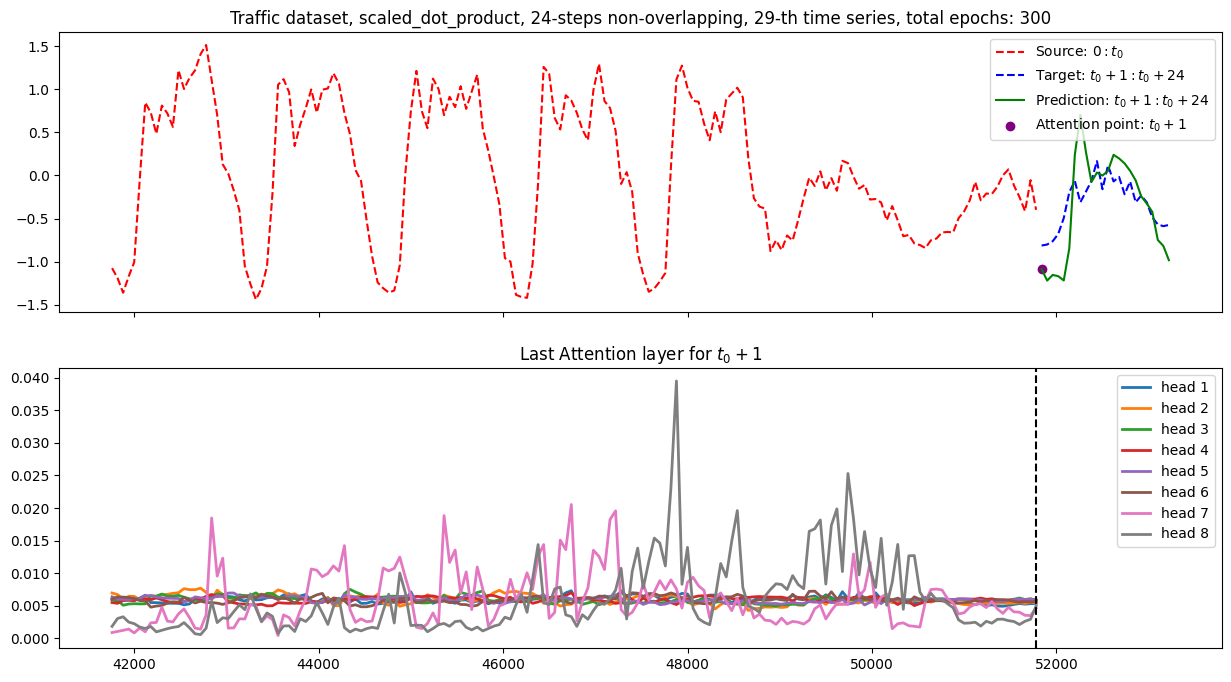

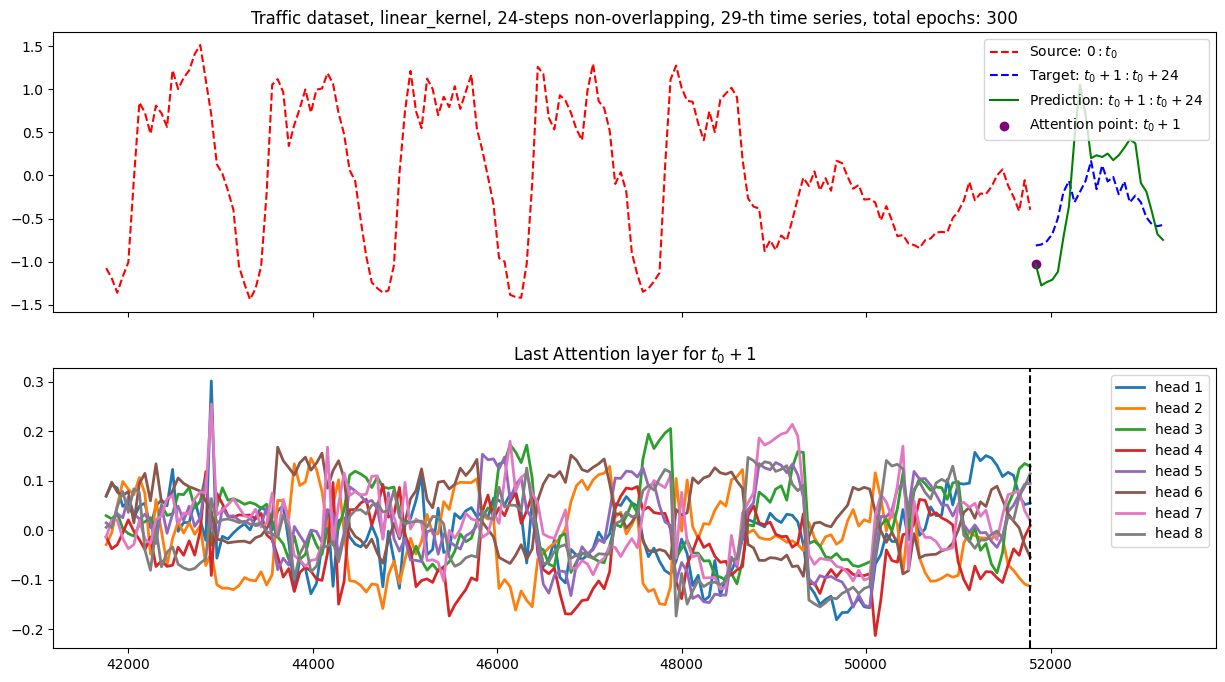

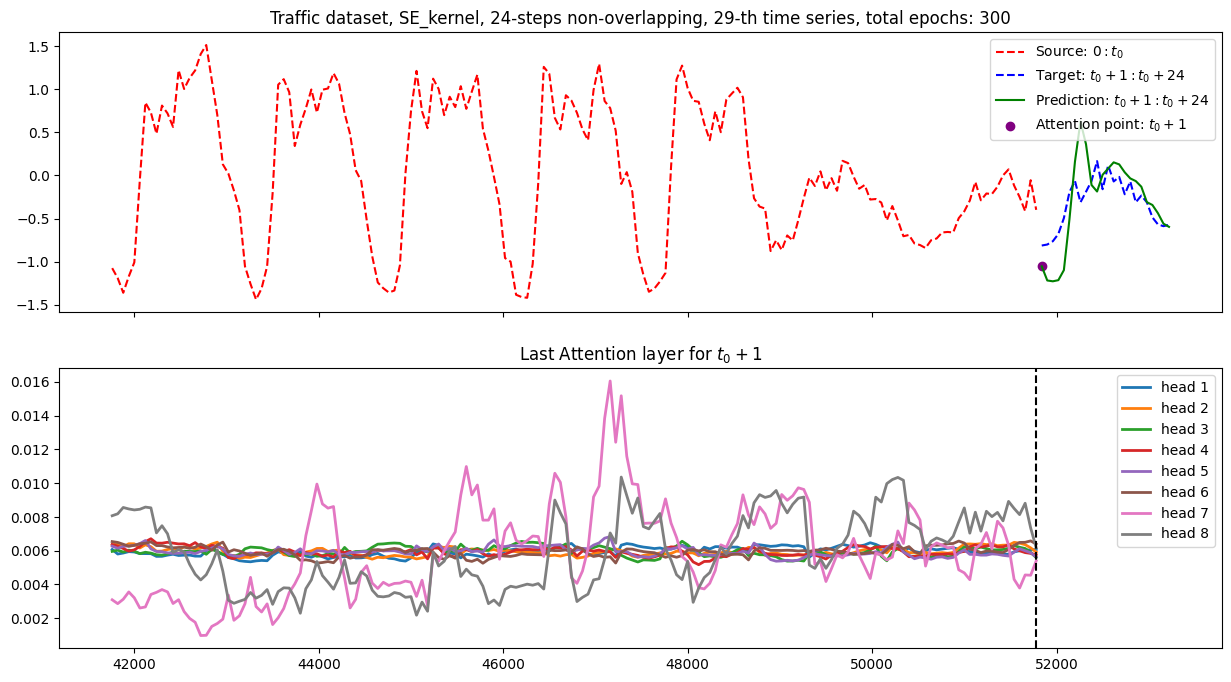

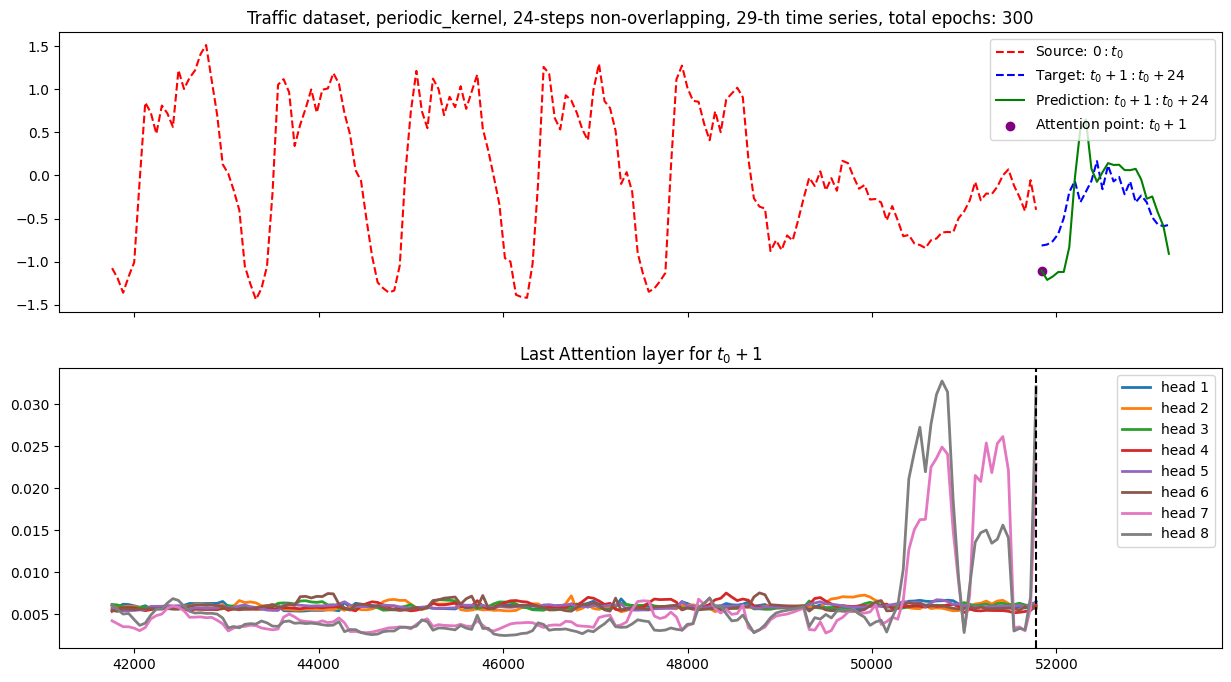

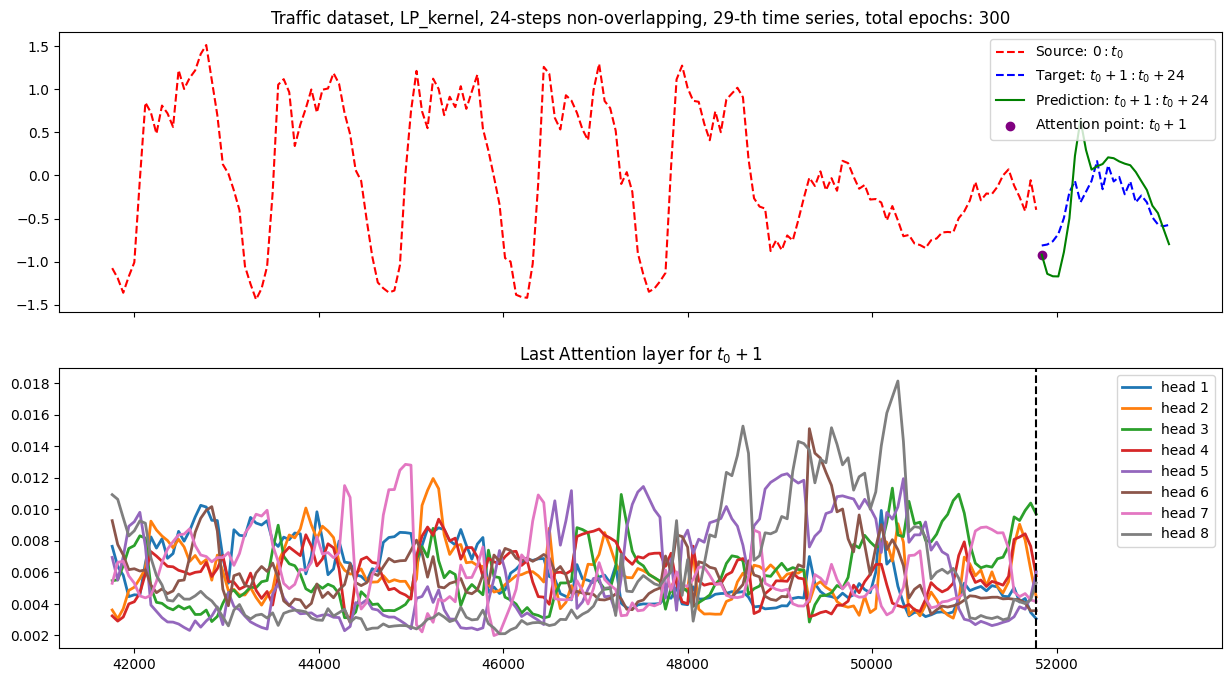

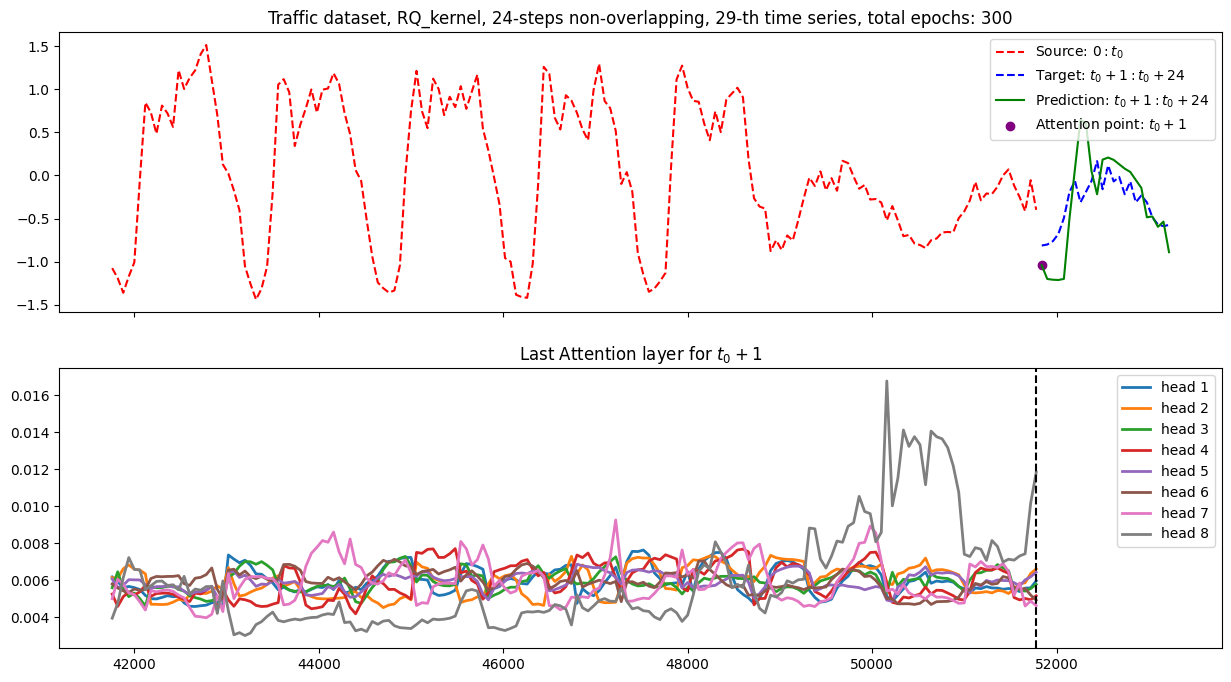

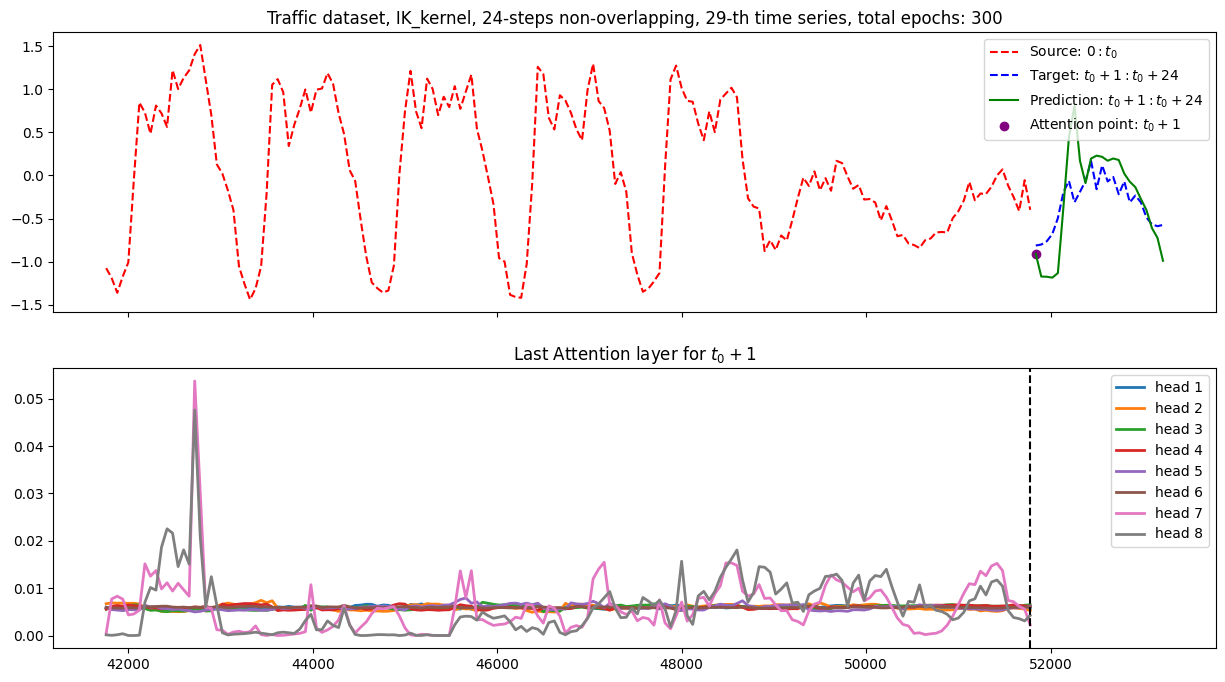

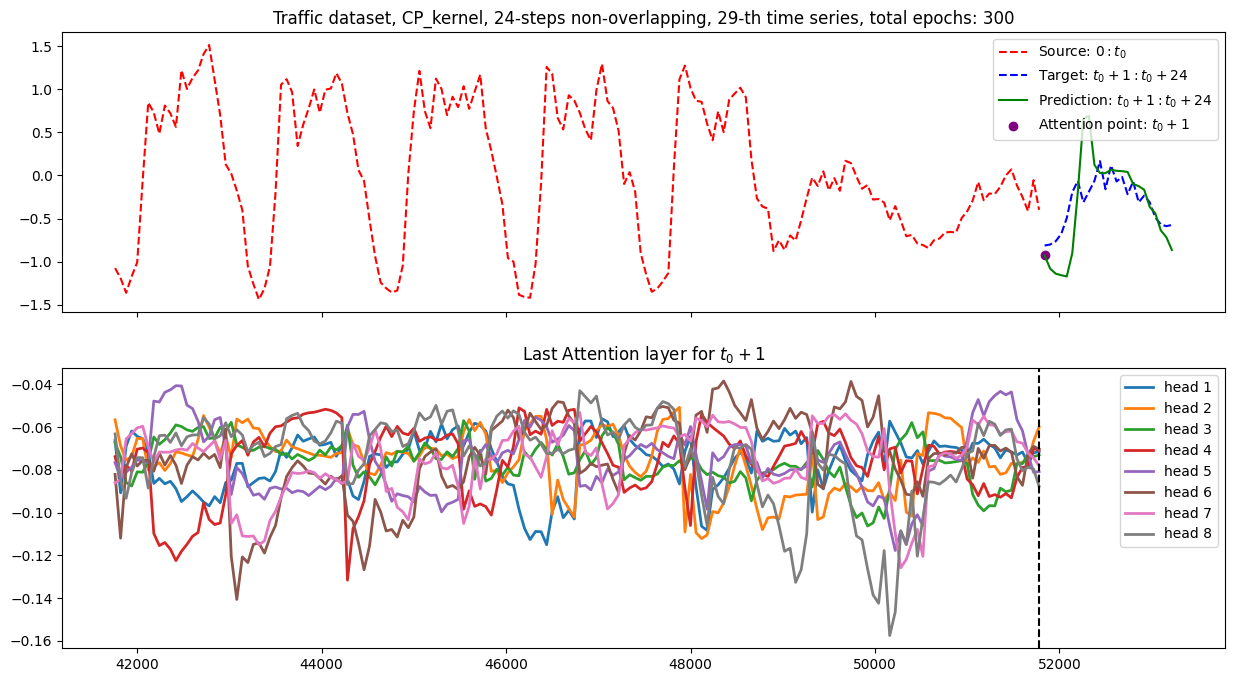

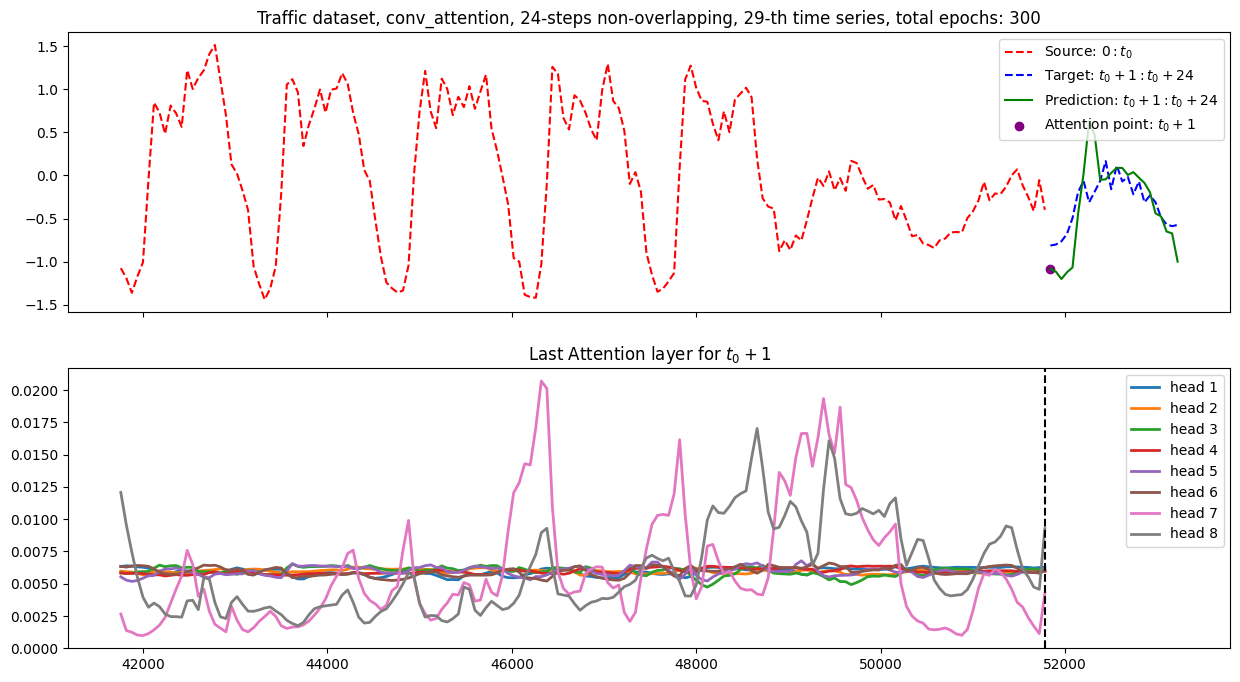

In [125]:
for name, model in models.items():
    attention_weights = []

    with torch.no_grad():
        model.eval()
        sample = dataset[idx]
        src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
        mask = dataset.mask.to(device)
        
        out = model(src_X, src_fX, mask)
        pred_fX = out[:, -shift:].squeeze().cpu()
        
        tgt_X = tgt_X.squeeze().cpu()
        tgt_fX = tgt_fX.squeeze().cpu()
        
        attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])
        
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    
    ax1.plot(src_X.squeeze().cpu()[:, 0], src_fX.squeeze().cpu()[:, ith], '--r', label="Source: $0:t_0$")
    ax1.plot(tgt_X[:, 0], tgt_fX[:, ith], '--b', label=f"Target: $t_0+1: t_0+{shift}$")
    ax1.plot(tgt_X[:, 0], pred_fX[:, ith], '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
    ax1.scatter(tgt_X[inspect_step, 0].cpu(), pred_fX.squeeze()[inspect_step, ith].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
    ax1.legend()
    ax1.set_title(f"Traffic dataset, {name}, {shift}-steps non-overlapping, {ith}-th time series, total epochs: {len(history[name][0])}")
    
    for i in range(n_layers-1, n_layers):
        for head_j in range(n_heads):
            attn = attention_weights[inspect_step][i][0, head_j, -1, :].cpu()
            if i == n_layers-1:
                ax2.plot(src_X.squeeze().cpu()[:, 0], attn, alpha=1, linewidth=2, label=f'head {head_j+1}')
            else:
                ax2.plot(src_X.squeeze().cpu()[:, 0], attn, alpha=0.6, linewidth=1, label=f'head {head_j+1}')
    
    ax2.set_title(f"Last Attention layer for $t_0+{inspect_step+1}$")
    ax2.axvline(src_X.squeeze().cpu()[-1, 0], linestyle='--', color='k')
    ax2.legend()
    
    # fig.savefig(f"../../img/{name}/traffic_{name}_{shift}preds.pdf", dpi=1200)